This notebook was generated using the pytorch implementations generated by Weihong that I started working with

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np
from collections import defaultdict


In [2]:
def main(result_path, feat_type=None, metric=None):
    
    assert feat_type is not None 
    assert metric is not None
    
    method_perf_dict = defaultdict(list)

    p = Path(result_path)
    p_list = list(p.glob(f"{feat_type}_test_results.csv"))
#     import ipdb
#     ipdb.set_trace()
    p_list = [x for x in p_list if feat_type in str(x)]
    
    
#     df = pd.read_csv(p_list[0], sep='\t')
    
    for path in tqdm(p_list):

        df = pd.read_csv(path, sep='\t')
        df = df[df["fsl"] == False]
        
        for group in (df[df['fsl'] == False]).groupby('classifier_type'):
            group_name, group_df = group
    
            if group_name in ['HD', 'HD-Sparse']:
                if metric == "train_time":
#                     encode_time = group_df.iloc[0]["encode_time"]
#                     train_time = group_df.iloc[0]["train_time"]
                    
#                     method_perf_dict[group_name].append(encode_time + train_time)
                    method_perf_dict[group_name].append(group_df.iloc[0][metric])
                else:
                    method_perf_dict[group_name].append(group_df.iloc[0][metric])
            elif group_name in ['MLP', 'L1', 'L2', 'Uniform']:
        
                method_perf_dict[group_name].append(group_df.iloc[0][metric])

#     return method_perf_dict
    method_perf_df = pd.DataFrame({"model": [key for key in method_perf_dict.keys()],
                                    metric: np.asarray([value for value in method_perf_dict.values()]).flatten()})
    
    return method_perf_df



def make_line_plot(perf_dict, title:str):

    f, ax = plt.subplots(1,1)
    
    for key, value in perf_dict.items():
    
        sns.lineplot(range(len(value)), [-1 * y for y in np.sort([-1*x for x in value])], ax=ax, label=key)
    
    ax.set_title(title)
    
    
def make_stacked_bar_plot(data_dir:Path, feat_type_list:list, metric_list:str, ylim=tuple, target_name=None):
    

    
    df_list = []
    if target_name is None:
        for feat_type in feat_type_list:
            df = pd.read_csv(f"{data_dir}/{feat_type}_test_results.csv", sep='\t')
            df["feat_type"] = [feat_type] * len(df)
            df_list.append(df)
            
    else:
        for feat_type in feat_type_list:
            df = pd.read_csv(f"{data_dir}/{target_name}_{feat_type}_test_results.csv", sep='\t')
            df["feat_type"] = [feat_type] * len(df)
            df_list.append(df)


    df = pd.concat(df_list, axis=0)
    df = df[df['success'] == True]

    
    df = df.drop([x for x in df.columns if x not in feat_type_list + metric_list + ['feat_type', 'num_epochs', 'classifier_type']], axis=1)
    
    
    

    
    

    for num_epochs, num_epochs_group_df in df.groupby('num_epochs'):
        
        f, ax = plt.subplots(1,
                         len(df['feat_type'].unique()), 
                         figsize=(24,3), sharex=True, sharey=True)
        ax = ax.flatten()

        for idx, group_tup in enumerate(num_epochs_group_df.groupby('feat_type')):
        
            feat_type, feat_group_df = group_tup
        


    
    
            feat_group_df = feat_group_df.drop('num_epochs', axis=1)

            feat_group_df.groupby('classifier_type').sum().plot(kind='bar', ax=ax[idx])
            ax[idx].set_yscale('log')
            ax[idx].set_title(f"{num_epochs}-{feat_type}")
            ax[idx].tick_params(axis='x', labelrotation = 40)


    
    
    
#     print(df.head())
    
#     from itertools import cycle
    
    
#         num_epochs, group_df = group_tup
#         g = sns.catplot(x='classifier_type', col="feat_type", data=group_df, saturation=.5,
#                    kind='bar')
#         g = sns.catplot(group_df,x='classifier_type', kind="bar", height=10)
#         g.map(plt.bar, metric, height=4)
#         print(idx)

#         colors = cycle(['steelblue', 'red'])
#         for metric in metric_list:
#             group_df.set_index('classifier_type').plot(y=metric, kind='bar', ax=ax[idx], color=next(colors)) #, 

#         group_df.set_index('classifier_type').plot(y=metric,kind='bar', stacked=True, ax=ax[idx]) #, color=['steelblue', 'red']
#         plt.grid()
        
#     plt.tight_layout()
    
    
    

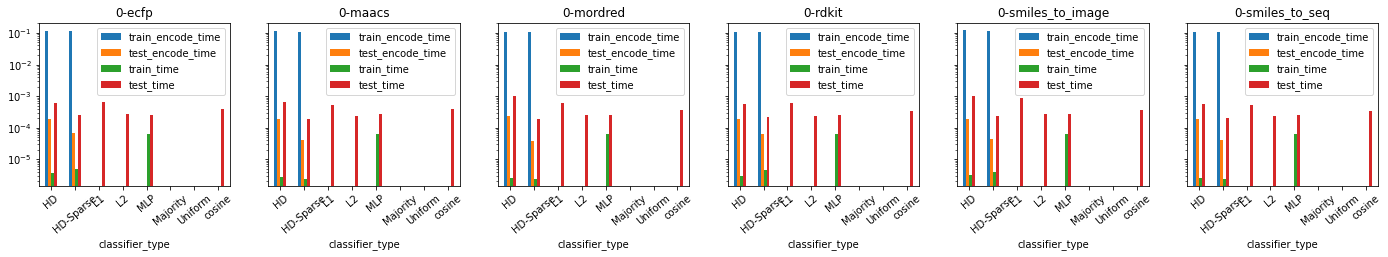

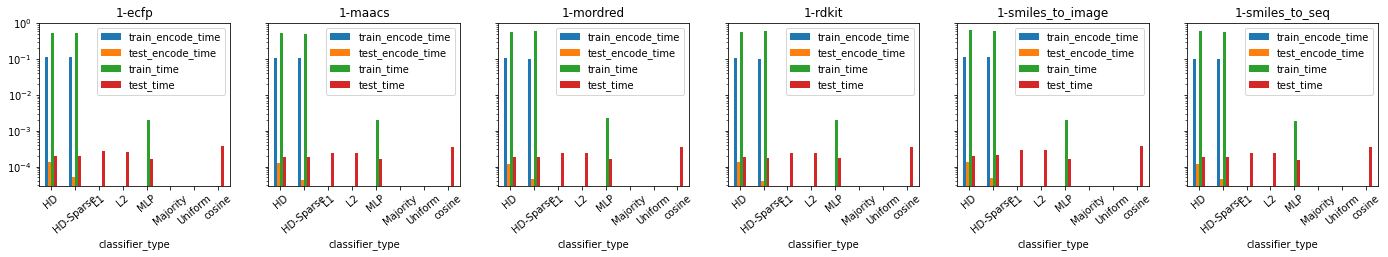

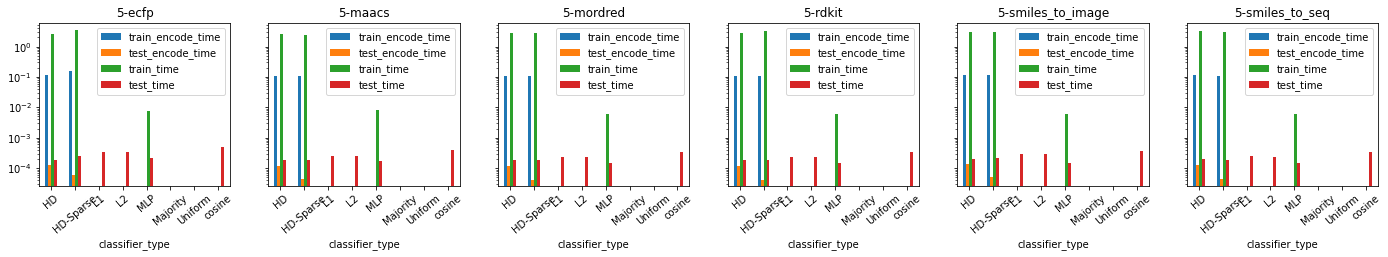

In [3]:
make_stacked_bar_plot(data_dir=Path('/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/fsl/results/postera'),
              feat_type_list=["ecfp", "smiles_to_seq", 
                              "smiles_to_image", "mordred", 
                              "maacs", "rdkit"], metric_list=["train_encode_time", "train_time", "test_time", "test_encode_time"], ylim=(0,2e-1))

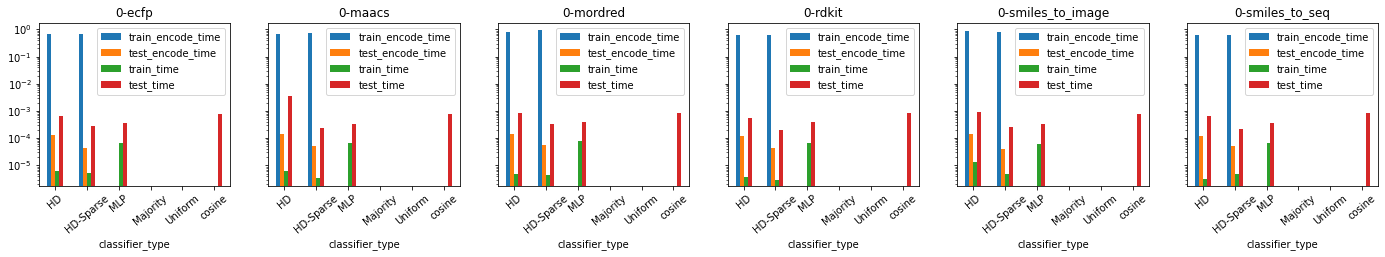

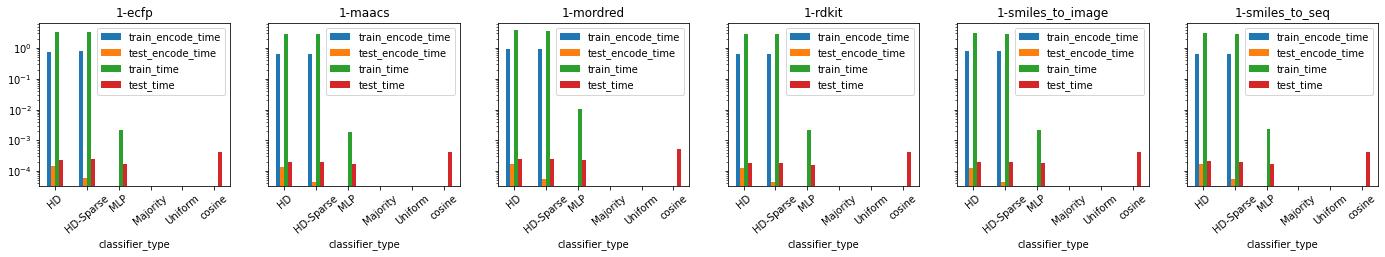

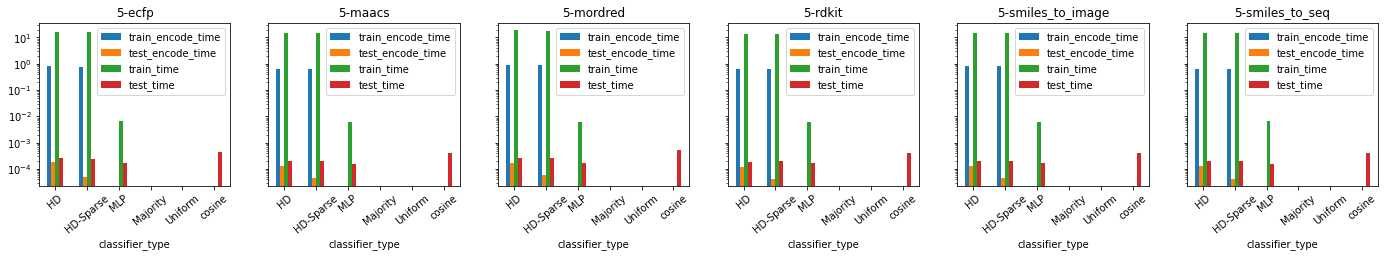

In [4]:
make_stacked_bar_plot(data_dir=Path('/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/fsl/results/dude'),
                      target_name="ace",
              feat_type_list=["ecfp", "smiles_to_seq", 
                              "smiles_to_image", "mordred", 
                              "maacs", "rdkit"], metric_list=["train_encode_time", "train_time", "test_time", "test_encode_time"], ylim=(0,2e-1))

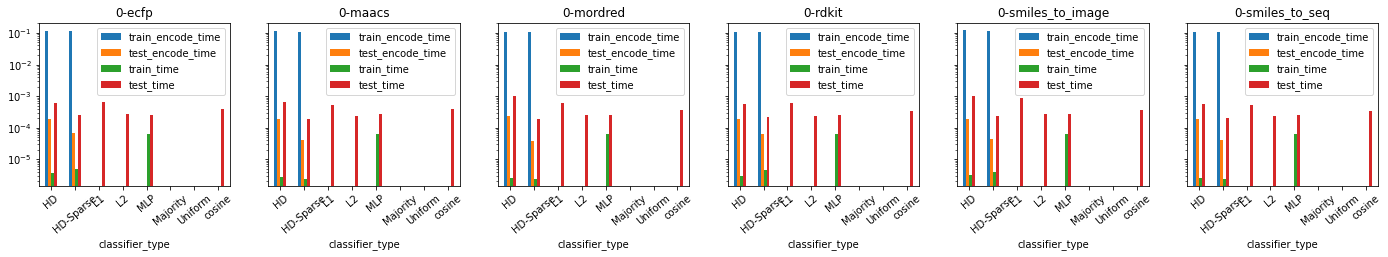

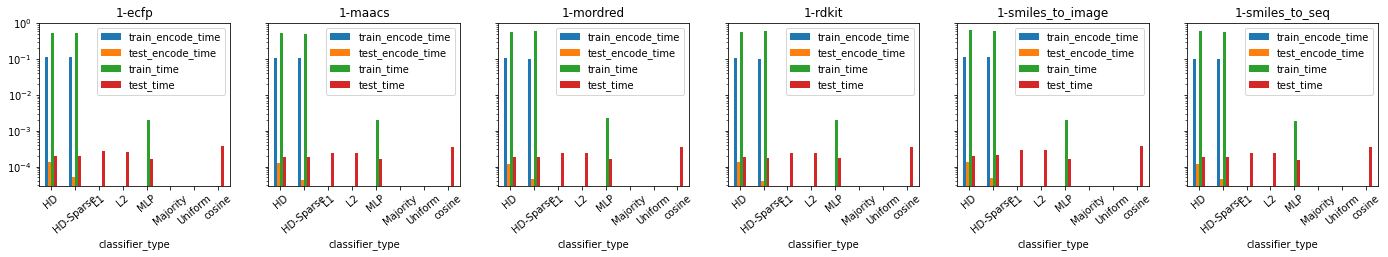

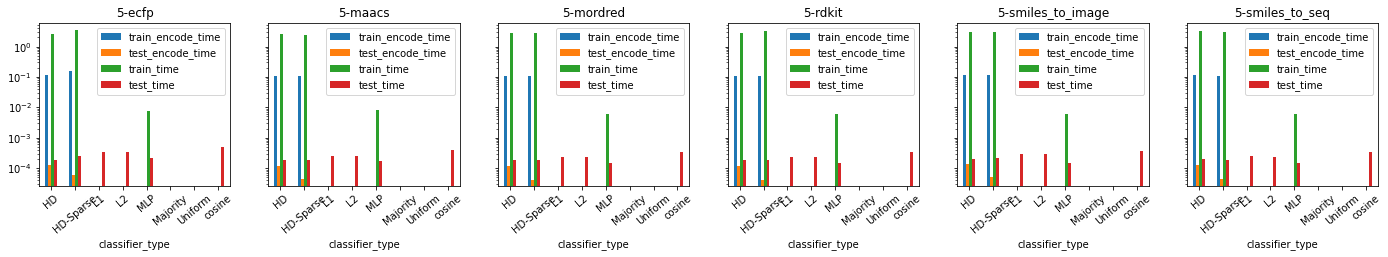

In [14]:
make_stacked_bar_plot(data_dir=Path('/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/fsl/results/postera'),
                      target_name=None,
              feat_type_list=["ecfp", "smiles_to_seq", 
                              "smiles_to_image", "mordred", 
                              "maacs", "rdkit"], metric_list=["train_encode_time", "train_time", "test_time", "test_encode_time"], ylim=(0,2e-1))

# Accuracy, Precision, Recall, F1 by number of training epochs

In [6]:
from pathlib import Path
def make_bar_plot(data_dir:Path, feat_type_list:list, metric:str, ylim=tuple):
    
    df_list = []
    for feat_type in feat_type_list:
        df = pd.read_csv(f"{data_dir}/{feat_type}_test_results.csv", sep='\t')
        df["feat_type"] = [feat_type] * len(df)
        df_list.append(df)


    df = pd.concat(df_list, axis=0)    
    
    
    df = df[df['success'] == True]

    
    for num_epochs, group_df in df.groupby('num_epochs'):


        g = sns.catplot(x='classifier_type', y=metric, col="feat_type", data=group_df, saturation=.5,
                   kind='bar', ci=None, aspect=.6)
    
        g = (g.set_axis_labels(f"num_epochs: {num_epochs}", metric)
              .set_xticklabels(["HD", "HD-Sparse", "L1", "L2", "cosine", "MLP", "Uniform"], rotation=45)
              .set_titles("{col_name}")
  .set(ylim=ylim)
            .despine(left=True))

    plt.tight_layout()
    plt.savefig(f"{data_dir.name}-{feat_type}-{metric}-{num_epochs}.png")

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (7).

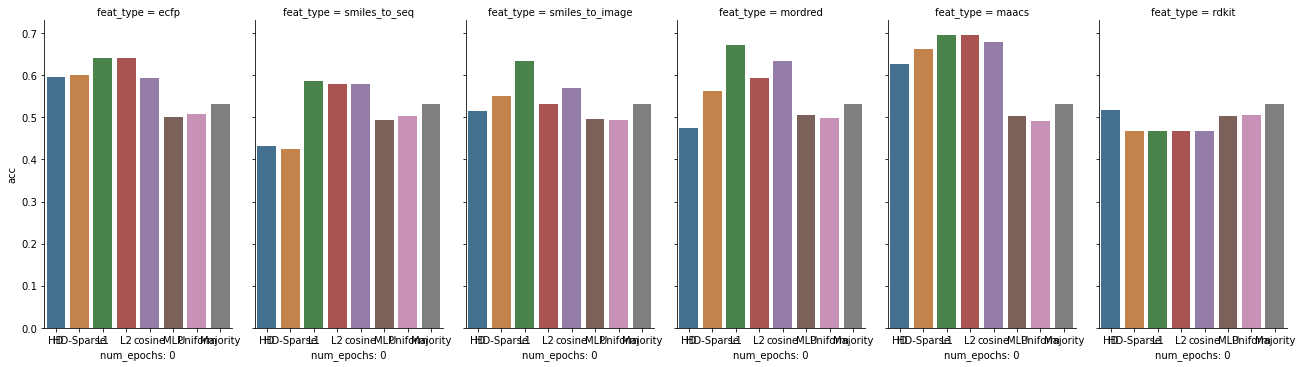

In [7]:
make_bar_plot(data_dir=Path('/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/fsl/results/postera'),
              feat_type_list=["ecfp", "smiles_to_seq", 
                              "smiles_to_image", "mordred", 
                              "maacs", "rdkit"], metric="acc", ylim=(0,100))

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (7).

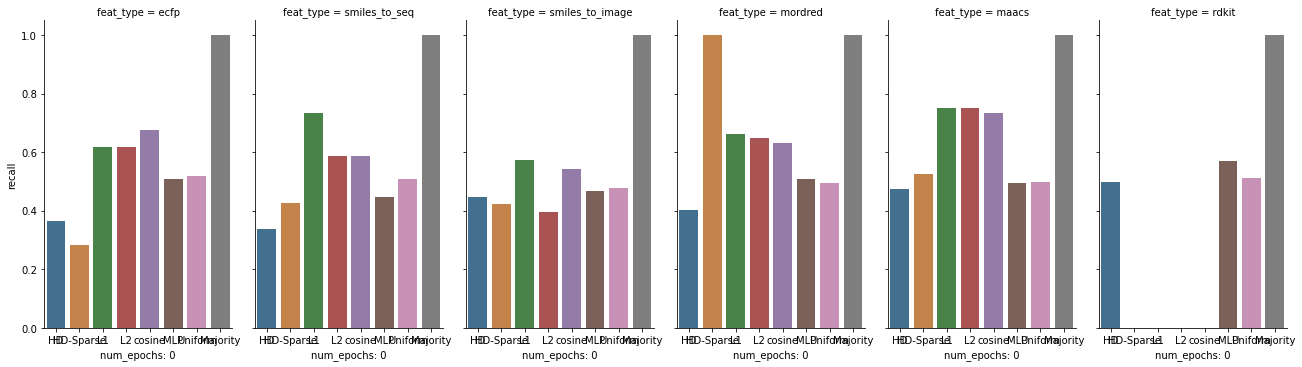

In [8]:
make_bar_plot(data_dir=Path('/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/fsl/results/postera'),
              feat_type_list=["ecfp", "smiles_to_seq", 
                              "smiles_to_image", "mordred", 
                              "maacs", "rdkit"], metric="recall", ylim=(0,1))

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (7).

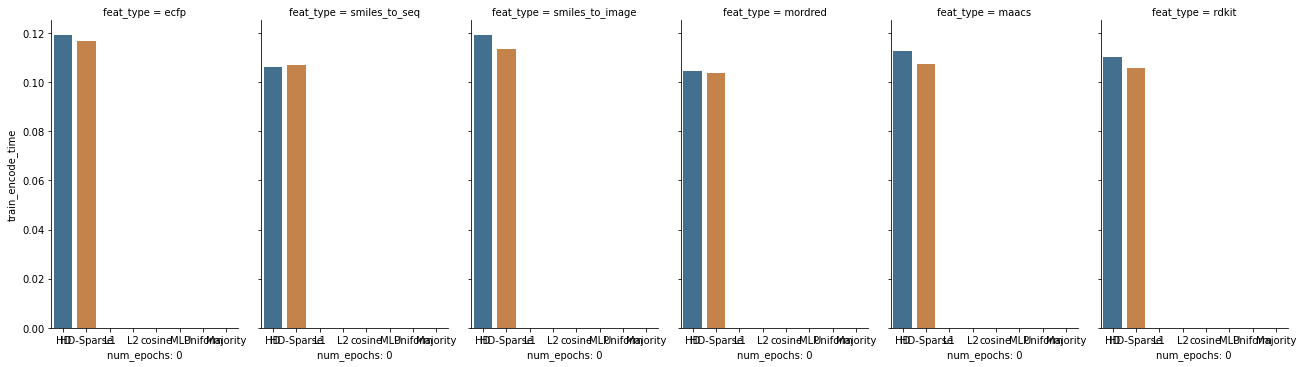

In [9]:
make_bar_plot(data_dir=Path('/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/fsl/results/postera'),
              feat_type_list=["ecfp", "smiles_to_seq", 
                              "smiles_to_image", "mordred", 
                              "maacs", "rdkit"], metric="train_encode_time", ylim=(0,2e-1))

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (7).

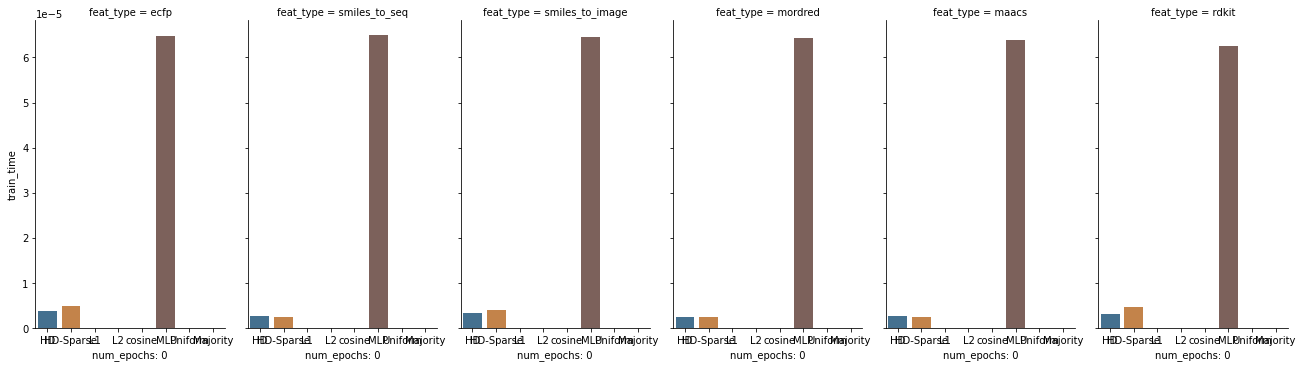

In [10]:
make_bar_plot(data_dir=Path('/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/fsl/results/postera'),
              feat_type_list=["ecfp", "smiles_to_seq", 
                              "smiles_to_image", "mordred", 
                              "maacs", "rdkit"], metric="train_time", ylim=None)

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (7).

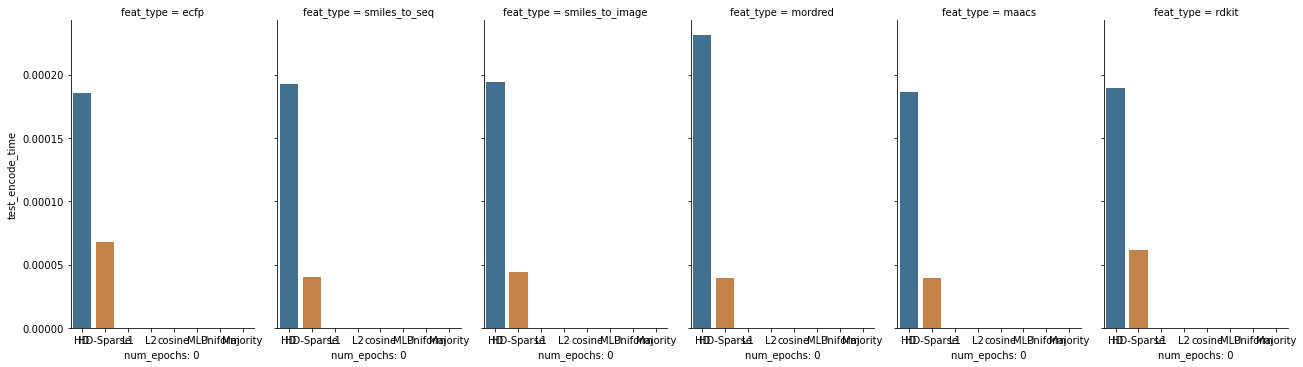

In [11]:
make_bar_plot(data_dir=Path('/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/fsl/results/postera'),
              feat_type_list=["ecfp", "smiles_to_seq", 
                              "smiles_to_image", "mordred", 
                              "maacs", "rdkit"], metric="test_encode_time", ylim=None)

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (7).

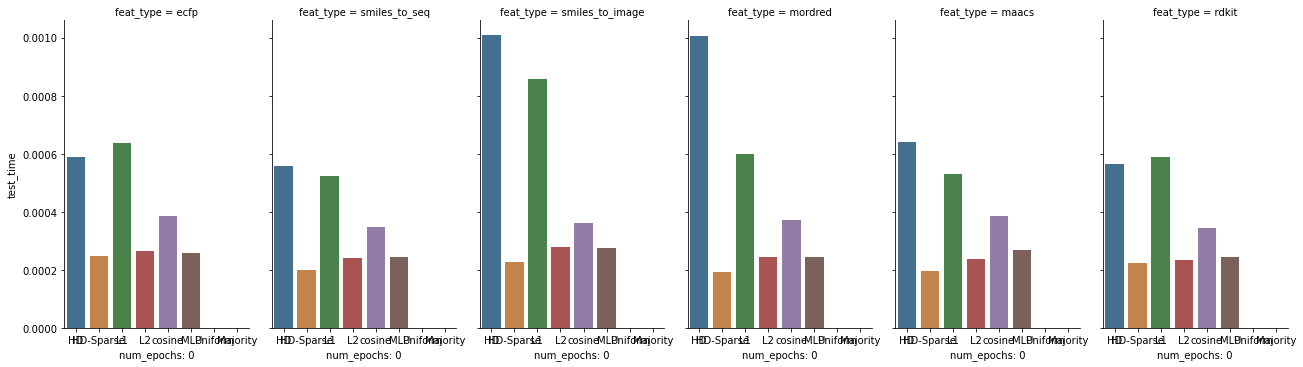

In [13]:
make_bar_plot(data_dir=Path('/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/fsl/results/postera'),
              feat_type_list=["ecfp", "smiles_to_seq", 
                              "smiles_to_image", "mordred", 
                              "maacs", "rdkit"], metric="test_time", ylim=None)